<a href="https://www.kaggle.com/code/dubeiebei/loan-risk-system?scriptVersionId=283094353" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#设置全局中文字体
font_path = '/kaggle/input/chinese-fonts/SourceHanSansSC-Regular.otf'
chinese_font = FontProperties(fname=font_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/kaggle/input/lending-club-data/loan_data_essential.csv',low_memory=False)
def preprocess_data(df):
    #format='%b-%Y'指出列'issue_d'的日期格式（比如'DEC-2015'）
    
    df['issue_d'] = pd.to_datetime(df['issue_d'],format='%b-%Y')
    #转换就业年限格式
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
    df['is_risk'] = df['loan_status'].apply(
        lambda x: 1 if x in ['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off', 'Default'] else 0
    )
    #处理缺失值：删除关键字段缺失样本
    df = df.dropna(subset=['emp_length', 'annual_inc', 'dti'])
    df = df.drop(columns=['loan_status'])
    #异常值处理--四分位检测法
    df = df[(df['annual_inc'] > 0) & (df['annual_inc'] < 200000)]
    #dti为借款人总债务（不包含房贷和当前贷款）与年收入的比率
    df = df[df['dti'] <= 60]
    return df
df_clean = preprocess_data(df)
print(f"预处理后数据维度: {df_clean.shape}")

#index=False不保存索引
df_clean.to_csv('preprocessed_loans.csv', index=False)
data = pd.read_csv('/kaggle/working/preprocessed_loans.csv')
data.is_risk.value_counts()

预处理后数据维度: (902215, 11)


is_risk
0    782153
1    120062
Name: count, dtype: int64

In [3]:
##特征工程
def feature_engineering(df):
    """创建风险分析特征"""
    # 1. 时间特征
    df['issue_year'] = df['issue_d'].dt.year
    df['issue_month'] = df['issue_d'].dt.month
    
    # 2. 贷款特征
    df['installment_ratio'] = df['installment'] / (df['annual_inc'] / 12)  # 月供占月收入比
    df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']  # 贷款收入比
    
    # 3. 信用特征
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_score'] = df['grade'].map(grade_map)
    
    # 4. 债务特征
    df['debt_burden'] = df['dti'] * df['installment_ratio']  # 综合债务负担
    
    # 5. 组合特征
    df['risk_factor'] = df['grade_score'] * df['installment_ratio'] * np.log1p(df['dti'])
    df['term_numeric'] = df['term'].str.extract('(\d+)').astype(int)
    
    return df


# 执行特征工程
df_features = feature_engineering(df_clean)
print("新增特征:", [col for col in df_features.columns if col not in df_clean.columns])
df_features.dtypes
df_features.installment_ratio.describe()


新增特征: []


count    902215.000000
mean          0.079918
std           0.047800
min           0.002102
25%           0.046885
50%           0.071757
75%           0.104026
max           5.594400
Name: installment_ratio, dtype: float64

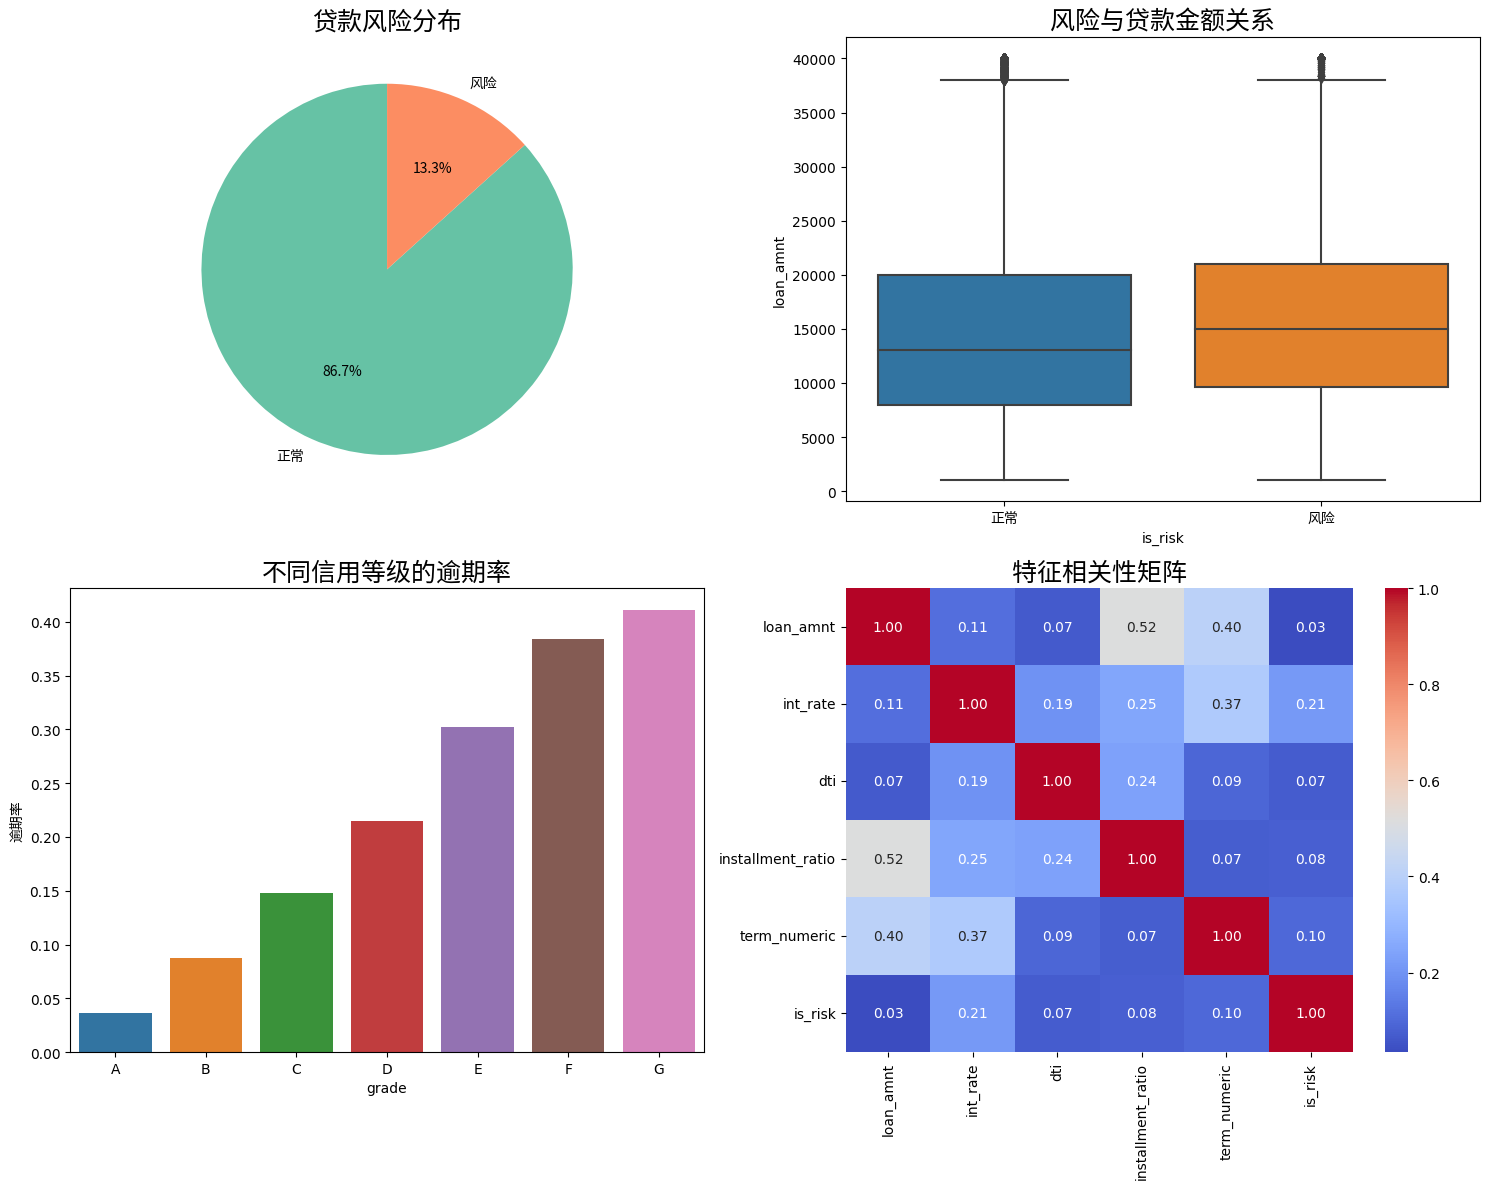

EDA完成! 结果已保存


In [4]:
### 步骤3：探索性数据分析（EDA）（2-3小时）
def perform_eda(df):
    """执行探索性数据分析"""
    numeric_df = df_features.select_dtypes(include=['int64','float64']).copy()
    
    plt.figure(figsize=(15, 12))
    
    # 1. 目标变量分布
    plt.subplot(2, 2, 1) #2行2列第一个子图
    risk_counts = df['is_risk'].value_counts()
    plt.pie(risk_counts, labels=['正常', '风险'], autopct='%1.1f%%', 
            colors=['#66c2a5', '#fc8d62'], startangle=90,textprops={'fontproperties': chinese_font})
    plt.title('贷款风险分布',fontproperties=chinese_font,size=18)
    
    # 2. 风险与贷款金额关系
    plt.subplot(2, 2, 2)
    sns.boxplot(x='is_risk', y='loan_amnt',data=df)
    plt.title('风险与贷款金额关系',fontproperties=chinese_font,size=18)
    plt.xticks([0, 1], ['正常', '风险'],fontproperties=chinese_font)
    
    # 3. 风险与信用等级关系
    plt.subplot(2, 2, 3)
    risk_by_grade = df.groupby('grade')['is_risk'].mean().reset_index()
    sns.barplot(x='grade', y='is_risk', data=risk_by_grade, order=list('ABCDEFG'))
    plt.title('不同信用等级的逾期率',fontproperties=chinese_font,size=18)
    plt.ylabel('逾期率',fontproperties=chinese_font)
    
    # 4. 特征相关性
    plt.subplot(2, 2, 4)
    corr_cols = ['loan_amnt', 'int_rate', 'dti', 'installment_ratio','term_numeric','is_risk']
    corr_matrix = numeric_df[corr_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt=".2f")
    plt.title('特征相关性矩阵',fontproperties=chinese_font,size=18)
    
    plt.tight_layout()
    plt.savefig('eda_results.png')
    plt.show()
    
    # 5. 保存EDA结果
    risk_corr = numeric_df.corr()['is_risk'].sort_values(ascending=False)
    risk_corr.to_csv('risk_correlations.csv',header=['correlation'])
    print("EDA完成! 结果已保存")

# 执行EDA
perform_eda(df_features)
    

In [5]:
risk_show = pd.read_csv('/kaggle/working/risk_correlations.csv')
risk_show

,Unnamed: 0,correlation
0,is_risk,1.000000
1,grade_score,0.240596
2,int_rate,0.214034
3,risk_factor,0.179426
4,term_numeric,0.096853
5,installment_ratio,0.076274
6,debt_burden,0.075960
7,loan_to_income,0.071539
8,dti,0.071464
9,installment,0.039422


In [6]:
#逻辑回归特征重要性分析
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
#选择特征（确保都是数值型）
features = ['loan_amnt','int_rate','emp_length','annual_inc','dti','installment_ratio','loan_to_income','grade_score','debt_burden','risk_factor','term_numeric']
X =df_features[features]
y = df_features['is_risk']
#标准化（逻辑回归需要）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#训练模型
model = LogisticRegression(max_iter=1000,class_weight='balanced')#处理不平衡数据
model.fit(X_scaled,y)
#查看系数
importance = pd.DataFrame({
    'feature':features,
    'coefficient':model.coef_[0],
    'abs_coeff':np.abs(model.coef_[0])
}).sort_values('abs_coeff',ascending=False)
print(importance)

              feature  coefficient  abs_coeff
7         grade_score     1.115991   1.115991
1            int_rate    -0.473588   0.473588
5   installment_ratio     0.444062   0.444062
6      loan_to_income    -0.269636   0.269636
4                 dti     0.184486   0.184486
8         debt_burden    -0.181307   0.181307
10       term_numeric     0.098186   0.098186
9         risk_factor    -0.074167   0.074167
3          annual_inc    -0.073509   0.073509
2          emp_length    -0.036278   0.036278
0           loan_amnt     0.021262   0.021262


<Axes: >

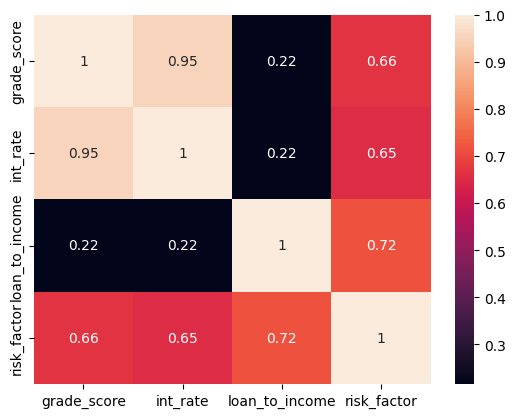

In [7]:
corr_matrix_1 = df_features[['grade_score','int_rate','loan_to_income','risk_factor']].corr()
sns.heatmap(corr_matrix_1,annot=True)

In [8]:
# 方法1：方差膨胀因子(VIF)检测
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF检测结果:")
print(vif_data.sort_values("VIF", ascending=False))

VIF检测结果:
              feature         VIF
6      loan_to_income  133.739525
1            int_rate   96.470359
5   installment_ratio   84.204524
7         grade_score   72.408316
10       term_numeric   53.170846
8         debt_burden   20.113435
9         risk_factor   16.260376
0           loan_amnt   15.319437
3          annual_inc   14.655120
4                 dti   14.572628
2          emp_length    3.816664


In [9]:
# 特征分类框架
basic_features = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti']
derived_features = ['installment_ratio', 'loan_to_income', 'grade_score', 
                   'debt_burden', 'risk_factor', 'term_numeric']

# 筛选策略
def select_features(df):
    """特征选择避免多重共线性"""
    # 保留基础特征
    selected = basic_features.copy()
    
    # 添加代表性衍生特征
    selected.append('installment_ratio')  # 比loan_to_income更直接
    
    # 添加重要特征
    selected.append('grade_score')
    
    # 添加必要特征
    selected.append('term_numeric')
    
    # 移除复合特征
    df = df.drop(columns=['loan_to_income', 'debt_burden', 'risk_factor'])
    
    return df[selected]

# 应用特征选择
X_selected = select_features(df_features)
print("筛选后特征:", X_selected.columns.tolist())

筛选后特征: ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'installment_ratio', 'grade_score', 'term_numeric']


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算筛选后特征的VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) 
                  for i in range(len(X_selected.columns))]

print("优化后VIF检测结果:")
print(vif_data.sort_values("VIF", ascending=False))

优化后VIF检测结果:
             feature        VIF
1           int_rate  86.151254
6        grade_score  58.002533
7       term_numeric  16.172436
0          loan_amnt  11.574969
3         annual_inc   9.297432
5  installment_ratio   8.885690
4                dti   5.712486
2         emp_length   3.731976


各信用等级平均利率:
grade
A     6.950756
B    10.357756
C    13.887538
D    17.939583
E    21.383348
F    25.653421
G    29.049247
Name: int_rate, dtype: float64


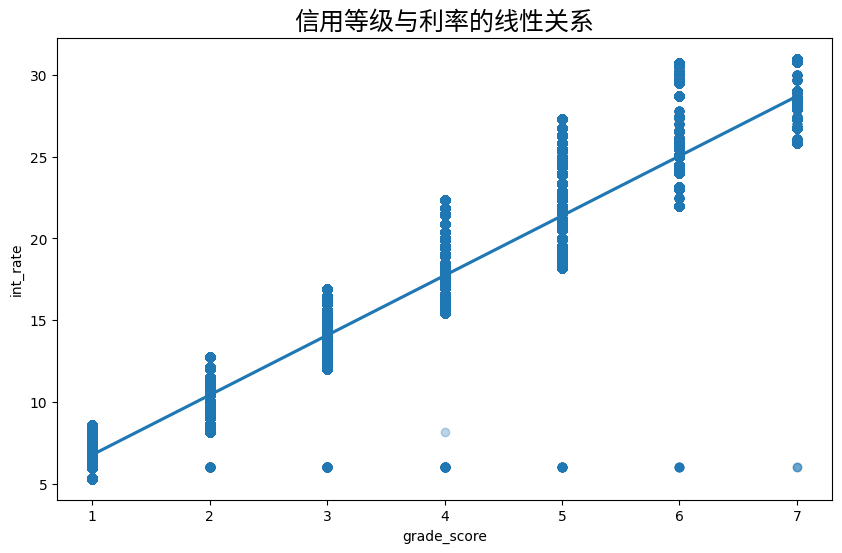

In [11]:
# 验证信用等级与利率的关系
grade_rate = df.groupby('grade')['int_rate'].mean()
print("各信用等级平均利率:")
print(grade_rate)

# 可视化关系-回归拟合散点图
plt.figure(figsize=(10,6))
sns.regplot(x='grade_score', y='int_rate', data=df_features, scatter_kws={'alpha':0.3})
plt.title('信用等级与利率的线性关系',fontproperties=chinese_font,size=18)
plt.savefig('grade_vs_rate.png')

In [12]:
def business_driven_features(df):
    """
    基于业务逻辑的特征选择
    解决多重共线性同时保留信息量
    """
    # 1. 处理高度相关对：二选一
    # 保留信用等级（更稳定），移除利率（由其决定）
    df = df.drop(columns=['int_rate'])
    
    # 2. 处理收入相关特征
    # 保留installment_ratio（最直接风险指标）
    df = df.drop(columns=['annual_inc', 'loan_amnt'])
    
    # 4. 移除低价值特征
    low_impact = ['emp_length']  # 根据前期分析
    df = df.drop(columns=low_impact)
    
    # 5. 最终特征集
    selected_features = [
        'grade_score',       # 核心信用指标
        'installment_ratio', # 还款压力指标
        'dti',               # 债务负担指标
        'term_numeric'               # 原始期限（36/60个月）
    ]
    
    return df[selected_features]

# 应用特征选择
X_final = business_driven_features(df_features)
X_final.head()

,grade_score,installment_ratio,dti,term_numeric
0,3,0.026843,5.91,36
1,3,0.151436,16.06,36
2,2,0.082411,10.78,60
3,3,0.090535,17.06,60
4,6,0.033312,25.37,60


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 计算最终VIF
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) 
                         for i in range(len(X_final.columns))]

print("最终VIF检测结果:")
print(vif_data_final.sort_values("VIF", ascending=False))

最终VIF检测结果:
             feature       VIF
3       term_numeric  8.681975
0        grade_score  6.808888
2                dti  5.337924
1  installment_ratio  3.999598


In [14]:
#基础建模
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib
# 准备数据
X = df_features[['dti','term_numeric','installment_ratio','grade_score']]
y = df_features['is_risk']

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
# 3. 训练随机森林模型
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=5,
    class_weight='balanced',  # 处理不平衡数据
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
# 4. 模型评估
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("准确率:", accuracy_score(y_test, y_pred))
    print("AUC分数:", roc_auc_score(y_test, y_proba))
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))
    # 混淆矩阵
    cm = pd.crosstab(y_test, y_pred, rownames=['实际'], colnames=['预测'])
    print("\n混淆矩阵:")
    print(cm)
    
    return y_proba

# 执行评估
test_predictions = evaluate_model(model, X_test, y_test)
# 5. 特征重要性分析
feature_importance = pd.Series(model.feature_importances_,index=X.columns)
print("\n特征重要性排序:")
print(feature_importance.sort_values(ascending=False))


准确率: 0.5877091380657604
AUC分数: 0.7026518059212222

分类报告:
              precision    recall  f1-score   support

           0       0.93      0.57      0.70    156212
           1       0.21      0.72      0.32     24231

    accuracy                           0.59    180443
   macro avg       0.57      0.65      0.51    180443
weighted avg       0.83      0.59      0.65    180443


混淆矩阵:
预测      0      1
实际              
0   88500  67712
1    6683  17548

特征重要性排序:
grade_score          0.813354
installment_ratio    0.080294
term_numeric         0.080133
dti                  0.026218
dtype: float64


In [15]:
# 设置月供比阈值
threshold = 0.4

# 创建分组
low_ratio = df_features[df_features['installment_ratio'] <= threshold]
high_ratio = df_features[df_features['installment_ratio'] > threshold]

In [16]:
# 计算低月供比组逾期率
risk_low = low_ratio['is_risk'].mean()

# 计算高月供比组逾期率
risk_high = high_ratio['is_risk'].mean()

print(f"月供比≤{threshold*100}%组逾期率: {risk_low:.3%}")
print(f"月供比>{threshold*100}%组逾期率: {risk_high:.3%}")

月供比≤40.0%组逾期率: 13.309%
月供比>40.0%组逾期率: 11.772%


In [17]:
risk_multiplier = risk_high / risk_low
print(f"风险提升倍数: {risk_multiplier:.1f}倍")

风险提升倍数: 0.9倍


In [18]:
# 假设您的数据在 df_cleaned 中，我们首先确保数据类型正确
df_features['installment_ratio'] = pd.to_numeric(df_features['installment_ratio'], errors='coerce')  # 转换为数值类型
df_features['is_risk'] = df_features['is_risk'].astype('category')  # 转换为分类变量

# Step 2: 处理缺失值
# 删除包含缺失值的行（或者可以填充为特定值）
df_features.dropna(subset=['installment_ratio', 'is_risk'], inplace=True)  # 删除含有 NaN 的行

# Step 3: 处理异常值（例如月供比异常大或者小）
# 假设月供比的合理范围是 0 到 1，我们可以过滤掉超出该范围的值
df_features = df_features[(df_features['installment_ratio'] >= 0) & (df_features['installment_ratio'] <= 1)]

# Step 4: 重新分组和计算每个分组中的逾期与未逾期用户数
low_ratio = df_features[df_features['installment_ratio'] <= 0.4]
high_ratio = df_features[df_features['installment_ratio'] > 0.4]

low_ratio_risk = low_ratio['is_risk'].value_counts()
high_ratio_risk = high_ratio['is_risk'].value_counts()

# Step 5: 创建列联表
contingency_table = [
    [low_ratio_risk.get(0, 0), low_ratio_risk.get(1, 0)],
    [high_ratio_risk.get(0, 0), high_ratio_risk.get(1, 0)]
]


In [19]:
from scipy.stats import chi2_contingency

# Step 6: 使用 chi2_contingency 计算卡方检验
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# 输出期望频数
print("期望频数表:")
print(expected)

# Step 7: 输出卡方统计量和p值
print(f"卡方统计量: {chi2_stat}")
print(f"p值: {p_value}")

# Step 8: 解释结果
if p_value < 0.05:
    print("结果显著，拒绝无关假设，表明月供比与逾期风险之间存在显著关系。")
else:
    print("结果不显著，无法拒绝无关假设，表明月供比与逾期风险之间没有显著关系。")


期望频数表:
[[7.81453065e+05 1.19954935e+05]
 [6.77935293e+02 1.04064707e+02]]
卡方统计量: 1.483750615142154
p值: 0.2231886245395071
结果不显著，无法拒绝无关假设，表明月供比与逾期风险之间没有显著关系。
